Authored by Somyajit Chakraborty, Department of Computer Science and Engineering, Techno India University, Kolkata
mailto: somyajitchppr@gmail.com

# Background Removal
The Background Removal Algorithms is one of the most commonly used algorithm with enormous real-world applications. Any Background Removal Algorithm uses image segmentation in its core build. Image segmentation is a Computer Vision model containing two subprocesses: object detection and instance/semantic segmentation. Here in the code below *decode_segmap* function is the object detection method also a helper function which helps the *segment* method. The *segment* function is the semantic segmentation model. The major difference between instance segmentation and semantic segmention is that instance segmentation seperates each object in an image and treasts them seperately, whereas semantic segmentation treats objects of same type like humans or cars as a group or a class. Our main objective is to extract human objects from our test images, so we have used semantic segmentation model developed by Google in 2017 (*Chen et al.*) called as deeplab_v3 RESNET101. Resnet 101 has recieved better results than previously used Resnet 50 models. The deeplab3 model can be found in the pytorch torchvision library models. So due to the lack of GPU/ NVIDIA CUDA I have used my local CPU to run the model. The removed background picture after processing is stored seperately for future use in the form of filename: bg_removedi.jpg where i is the input file number. 

#### Challenges:
1. The input tanken is manual. Due to lack of CPU processing power the automation of the process is difficult.
2. Lack of GPU.
3. Keeping few background elements occured in one image 6.(almost negligible)

#### References:
1. Chen, Liang-Chieh et al. “DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs.” IEEE Transactions on Pattern Analysis and Machine Intelligence 40 (2018): 834-848.

In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# torchvision transformation
import torchvision.transforms as T

In [2]:
# The helper function definition
def decode_segmap(image, source, nc=21):
    """
    decode image to detect objects
    """
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = cv2.imread(source)

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

In [120]:
def segment(net, path, show_orig=True, dev='cpu'):
  """
  deeplabv3_resnet101 semantic segmentation
  """
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
  rgb = decode_segmap(om, path)
     
  plt.imshow(rgb); plt.axis('off'); plt.savefig('bg_removed10.jpg'); plt.show()

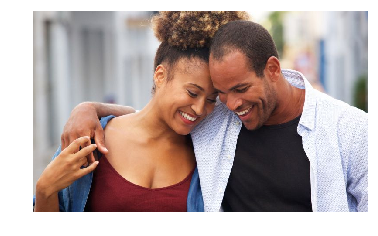

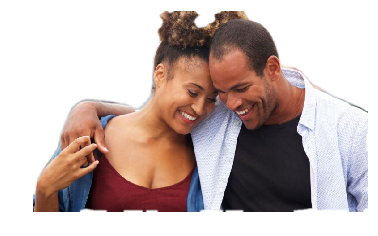

In [121]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

segment(dlab, 'person10.jpg', show_orig=True)

# Cartoonizing Image
Cartoonizing images is becoming a very popular social meadia feat currently. Cartoonizing images can be done very simply using OpenCV's bilateral filter after extracting image edges. But the process is not very accurate and rather has a bad presentation. So in order to cartoonize the background removed images I have used the concept of image colouring using K-means clustering and histogram distribution plot. Together this algorithm is called K-Histogram model describe in *Lin et al. 2019*, which takes the best K value in combination with the standard centroid inputs. I have used 4 methods to udertake the task. The first method *cartoonize()*  is the main fuction which uses the k-histogram model to colorize the picture and is then converted to HSV(Hue, Saturation, Value) before output. The second method is a helper function *update_C()* is for centroid calculations. The third method is our K-histogram Model written as *k_histogram()*. Finally the fouth method is the *show_image()* for display. The cartoonized image is saved as: cartooni.jpg where is i is the input image number.   

#### References:
1. H. Lin, S. Li, J. Zhao and G. Qiu, "Image based on histogram and K-Means clustering segmentation algorithm," 2019 IEEE 3rd Advanced Information Management, Communicates, Electronic and Automation Control Conference (IMCEC), Chongqing, China, 2019, pp. 892-895, doi: 10.1109/IMCEC46724.2019.8983843.

In [16]:
import argparse
import time
import numpy as np
from collections import defaultdict
from scipy import stats

In [122]:

def cartoonize(image):
    """
    convert image into cartoon-like image
    image: input PIL image
    """

    output = np.array(image)
    x, y, c = output.shape
    hists = []
    for i in range(c):
        output[:, :, i] = cv2.bilateralFilter(output[:, :, i], 5, 50, 50)

    edge = cv2.Canny(output, 100, 200)
    show_image(output)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)

    #H
    hist, _ = np.histogram(output[:, :, 0], bins=np.arange(180+1))
    hists.append(hist)
    #S
    hist, _ = np.histogram(output[:, :, 1], bins=np.arange(256+1))
    hists.append(hist)
    #V
    hist, _ = np.histogram(output[:, :, 2], bins=np.arange(256+1))
    hists.append(hist)
    
    C = []
    for h in hists:
        C.append(k_histogram(h))
    print("centroids: {0}".format(C))
    show_image(output)
    output = output.reshape((-1, c))
    for i in range(c):
        channel = output[:, i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:, i] = C[i][index]
    output = output.reshape((x, y, c))
    show_image(output)
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    show_image(edge)
    contours, _ = cv2.findContours(edge,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)

    show_image(cv2.drawContours(output, contours, -1, 0, thickness=1))
    return output

In [123]:
def update_C(C, hist):
    """
    update centroids until they don't change
    """
    while True:
        groups = defaultdict(list)
        #assign pixel values
        for i in range(len(hist)):
            if hist[i] == 0:
                continue
            d = np.abs(C-i)
            index = np.argmin(d)
            groups[index].append(i)

        new_C = np.array(C)
        for i, indice in groups.items():
            if np.sum(hist[indice]) == 0:
                continue
            new_C[i] = int(np.sum(indice*hist[indice])/np.sum(hist[indice]))
        if np.sum(new_C-C) == 0:
            break
        C = new_C
    return C, groups

In [127]:
def k_histogram(hist):
    """
    choose the best K for k-means and get the centroids
    """
    alpha = 0.001              # p-value threshold for normaltest
    N = 80                      # minimun group size for normaltest
    C = np.array([128])

    while True:
        C, groups = update_C(C, hist)

        # increase K vale if possible
        new_C = set()     # use set to avoid same value when seperating centroid
        for i, indice in groups.items():
            #if there are not enough values in the group, do not seperate
            if len(indice) < N:
                new_C.add(C[i])
                continue

            # evaluation to seperate the centroid by testing if the values of the group is under a normal distribution
            z, pval = stats.normaltest(hist[indice])
            if pval < alpha:
                # if not a normal dist, seperate
                left = 0 if i == 0 else C[i-1]
                right = len(hist)-1 if i == len(C)-1 else C[i+1]
                delta = right-left
                if delta >= 3:
                    c1 = (C[i]+left)/2
                    c2 = (C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    # though it is not a normal dist, we have no
                    # extra space to seperate
                    new_C.add(C[i])
            else:
                # normal dist, no need to seperate
                new_C.add(C[i])
        if len(new_C) == len(C):
            break
        else:
            C = np.array(sorted(new_C))
    return C

In [128]:
def show_image(img):
    cv2.imshow('Image' , img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [129]:
image = cv2.imread('bg_removed10.jpg')
output = cartoonize(image)
show_image(output)

In [130]:
cv2.imwrite('cartoon10.jpg', output)


True

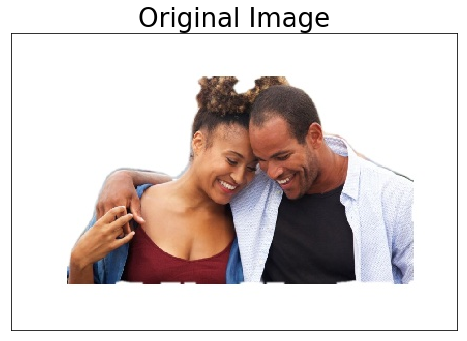

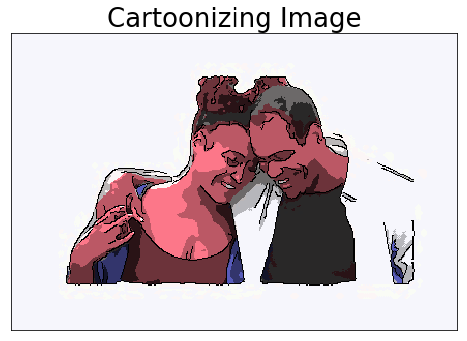

In [131]:
#Displaying input
plt.figure(num = 1, figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=26)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()
#Display output
plt.figure(num = 1, figsize=(8,8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Cartoonizing Image', fontsize=26)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

# Accuracy Test
In order yo perform a preliminary accuracy test on the transformation I have used the concept of Mean Square Error(MSE) and Structural Similarity Index Measure (SSIM) which is available in scikit-learn image package. The mathematical formula of MSE and SSIM is given as follows:
<img src="formula.png" alt="formula" align="center" width="500"/>
The average accuracy of the entire transformation is found to 86.2%(based on SSIM) and the MSE is in resonable range, with peak accuracy of 94.1% shown in the output section.

In [93]:
from skimage.metrics import structural_similarity as ssim
img_original = image
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
img_original = cv2.resize(img_original, (640,480))
img_cartoon = output
img_cartoon = cv2.cvtColor(img_cartoon, cv2.COLOR_BGR2RGB)
img_cartoon = cv2.resize(img_cartoon, (640,480))

In [94]:
#MSE
def mse(img_act, img_test):
    err = np.sum((img_act.astype("float") - img_test.astype("float")) ** 2)
    err /= float(img_act.shape[0] * img_test.shape[1])
    
    return err

In [95]:
m = mse(img_original, img_cartoon)
s = ssim(img_original, img_cartoon, multichannel=True)

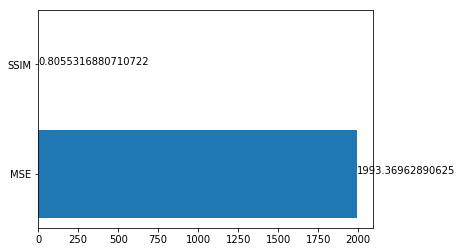

In [96]:
measure = ['MSE', 'SSIM']
value = [(float(m)), (float(s))]
plt.barh(measure, value)
for index, val in enumerate(value):
    plt.text(val, index, str(val))

plt.show()

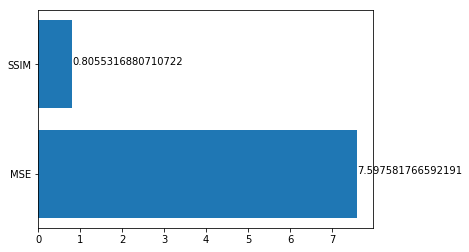

In [97]:
# Parameter Normalization by transforming MSE to Log MSE
measure = ['MSE', 'SSIM']
value = [np.log(float(m)), (float(s))]
plt.barh(measure, value)
for index, val in enumerate(value):
    plt.text(val, index, str(val))

plt.show()

# Outputs
Contains the overall output of the entire model

In [101]:
# input
input1 = cv2.imread('person1.jpg')
input1 = cv2.cvtColor(input1, cv2.COLOR_BGR2RGB)
input2 = cv2.imread('person2.jpg')
input2 = cv2.cvtColor(input2, cv2.COLOR_BGR2RGB)
input3 = cv2.imread('person3.jpg')
input3 = cv2.cvtColor(input3, cv2.COLOR_BGR2RGB)
input4 = cv2.imread('person4.jpg')
input4 = cv2.cvtColor(input4, cv2.COLOR_BGR2RGB)
input5 = cv2.imread('person5.jpg')
input5 = cv2.cvtColor(input5, cv2.COLOR_BGR2RGB)
input6 = cv2.imread('person6.jpg')
input6 = cv2.cvtColor(input6, cv2.COLOR_BGR2RGB)
input7 = cv2.imread('person7.jpg')
input7 = cv2.cvtColor(input7, cv2.COLOR_BGR2RGB)
input8 = cv2.imread('person8.jpg')
input8 = cv2.cvtColor(input8, cv2.COLOR_BGR2RGB)
input9 = cv2.imread('person9.jpg')
input9 = cv2.cvtColor(input9, cv2.COLOR_BGR2RGB)
input10 = cv2.imread('person10.jpg')
input10 = cv2.cvtColor(input10, cv2.COLOR_BGR2RGB)


# background removed
image1 = cv2.imread('bg_removed1.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread('bg_removed2.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.imread('bg_removed3.jpg')
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image4 = cv2.imread('bg_removed4.jpg')
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
image5 = cv2.imread('bg_removed5.jpg')
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2RGB)
image6 = cv2.imread('bg_removed6.jpg')
image6 = cv2.cvtColor(image6, cv2.COLOR_BGR2RGB)
image7 = cv2.imread('bg_removed7.jpg')
image7 = cv2.cvtColor(image7, cv2.COLOR_BGR2RGB)
image8 = cv2.imread('bg_removed8.jpg')
image8 = cv2.cvtColor(image8, cv2.COLOR_BGR2RGB)
image9 = cv2.imread('bg_removed9.jpg')
image9 = cv2.cvtColor(image9, cv2.COLOR_BGR2RGB)
image10 = cv2.imread('bg_removed10.jpg')
image10 = cv2.cvtColor(image10, cv2.COLOR_BGR2RGB)

# cartoonified output
output1 = cv2.imread('cartoon1.jpg')
output1 = cv2.cvtColor(output1, cv2.COLOR_BGR2RGB)
output2 = cv2.imread('cartoon2.jpg')
output2 = cv2.cvtColor(output2, cv2.COLOR_BGR2RGB)
output3 = cv2.imread('cartoon3.jpg')
output3 = cv2.cvtColor(output3, cv2.COLOR_BGR2RGB)
output4 = cv2.imread('cartoon4.jpg')
output4 = cv2.cvtColor(output4, cv2.COLOR_BGR2RGB)
output5 = cv2.imread('cartoon5.jpg')
output5 = cv2.cvtColor(output5, cv2.COLOR_BGR2RGB)
output6 = cv2.imread('cartoon6.jpg')
output6 = cv2.cvtColor(output6, cv2.COLOR_BGR2RGB)
output7 = cv2.imread('cartoon7.jpg')
output7 = cv2.cvtColor(output7, cv2.COLOR_BGR2RGB)
output8 = cv2.imread('cartoon8.jpg')
output8 = cv2.cvtColor(output8, cv2.COLOR_BGR2RGB)
output9 = cv2.imread('cartoon9.jpg')
output9 = cv2.cvtColor(output9, cv2.COLOR_BGR2RGB)
output10 = cv2.imread('cartoon10.jpg')
output10 = cv2.cvtColor(output10, cv2.COLOR_BGR2RGB)

(-0.5, 767.5, 460.5, -0.5)

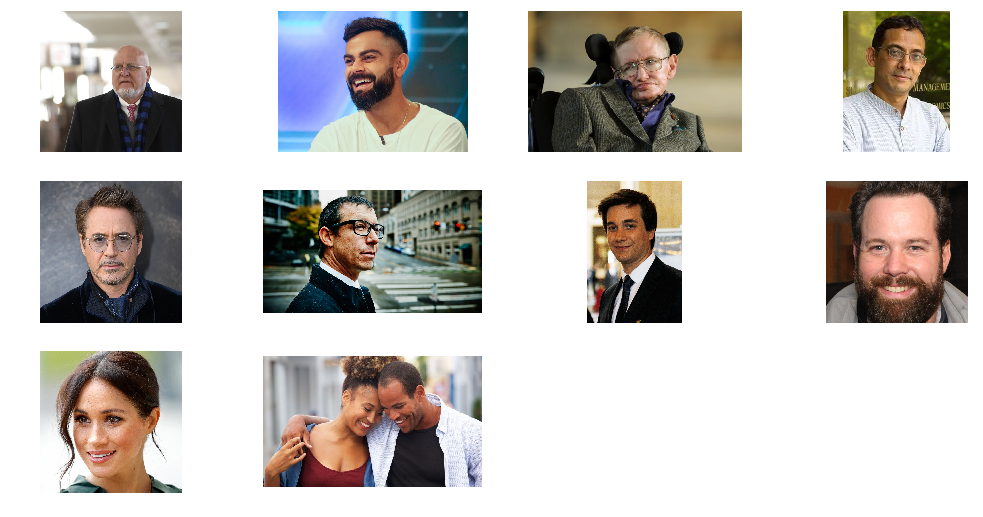

In [102]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(4,4,1)
ax1.imshow(input1)
ax1.axis('off')
ax2 = fig.add_subplot(4,4,2)
ax2.imshow(input2)
ax2.axis('off')
ax3 = fig.add_subplot(4,4,3)
ax3.imshow(input3)
ax3.axis('off')
ax4 = fig.add_subplot(4,4,4)
ax4.imshow(input4)
ax4.axis('off')
ax5 = fig.add_subplot(4,4,5)
ax5.imshow(input5)
ax5.axis('off')
ax6 = fig.add_subplot(4,4,6)
ax6.imshow(input6)
ax6.axis('off')
ax7 = fig.add_subplot(4,4,7)
ax7.imshow(input7)
ax7.axis('off')
ax8 = fig.add_subplot(4,4,8)
ax8.imshow(input8)
ax8.axis('off')
ax9 = fig.add_subplot(4,4,9)
ax9.imshow(input9)
ax9.axis('off')
ax10 = fig.add_subplot(4,4,10)
ax10.imshow(input10)
ax10.axis('off')

(-0.5, 431.5, 287.5, -0.5)

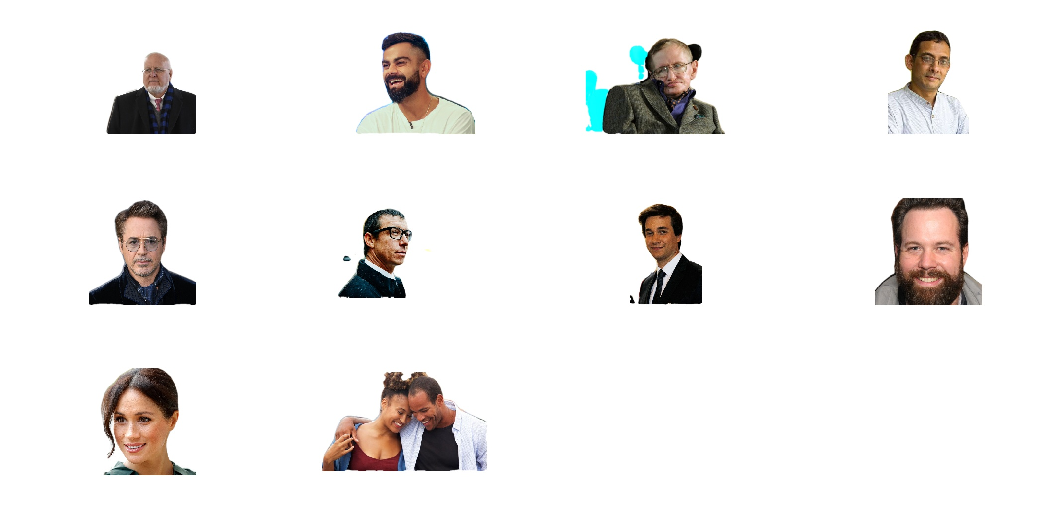

In [103]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(4,4,1)
ax1.imshow(image1)
ax1.axis('off')
ax2 = fig.add_subplot(4,4,2)
ax2.imshow(image2)
ax2.axis('off')
ax3 = fig.add_subplot(4,4,3)
ax3.imshow(image3)
ax3.axis('off')
ax4 = fig.add_subplot(4,4,4)
ax4.imshow(image4)
ax4.axis('off')
ax5 = fig.add_subplot(4,4,5)
ax5.imshow(image5)
ax5.axis('off')
ax6 = fig.add_subplot(4,4,6)
ax6.imshow(image6)
ax6.axis('off')
ax7 = fig.add_subplot(4,4,7)
ax7.imshow(image7)
ax7.axis('off')
ax8 = fig.add_subplot(4,4,8)
ax8.imshow(image8)
ax8.axis('off')
ax9 = fig.add_subplot(4,4,9)
ax9.imshow(image9)
ax9.axis('off')
ax10 = fig.add_subplot(4,4,10)
ax10.imshow(image10)
ax10.axis('off')

(-0.5, 431.5, 287.5, -0.5)

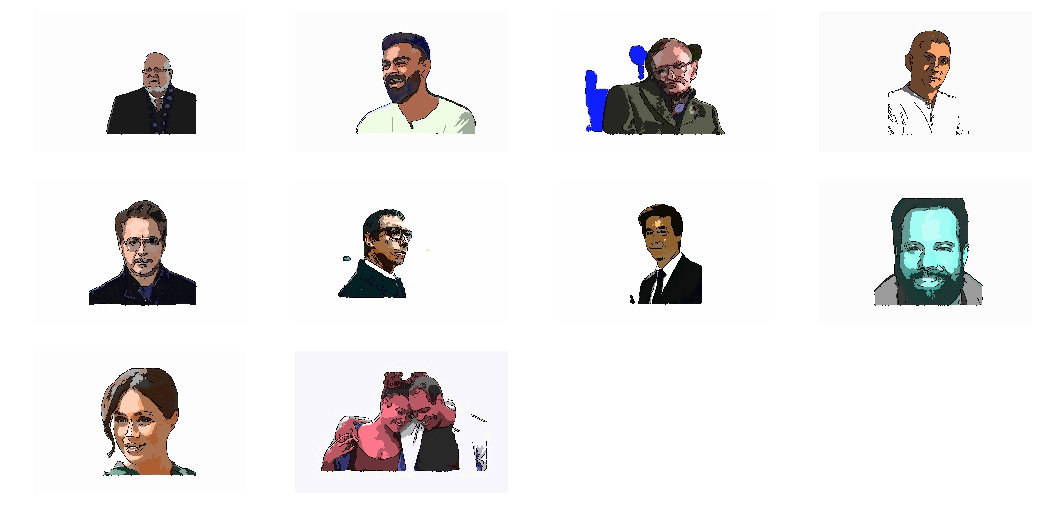

In [104]:
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(4,4,1)
ax1.imshow(output1)
ax1.axis('off')
ax2 = fig.add_subplot(4,4,2)
ax2.imshow(output2)
ax2.axis('off')
ax3 = fig.add_subplot(4,4,3)
ax3.imshow(output3)
ax3.axis('off')
ax4 = fig.add_subplot(4,4,4)
ax4.imshow(output4)
ax4.axis('off')
ax5 = fig.add_subplot(4,4,5)
ax5.imshow(output5)
ax5.axis('off')
ax6 = fig.add_subplot(4,4,6)
ax6.imshow(output6)
ax6.axis('off')
ax7 = fig.add_subplot(4,4,7)
ax7.imshow(output7)
ax7.axis('off')
ax8 = fig.add_subplot(4,4,8)
ax8.imshow(output8)
ax8.axis('off')
ax9 = fig.add_subplot(4,4,9)
ax9.imshow(output9)
ax9.axis('off')
ax10 = fig.add_subplot(4,4,10)
ax10.imshow(output10)
ax10.axis('off')

In [107]:
m1 = mse(image1, output1)
s1 = ssim(image1, output1, multichannel=True)

m2 = mse(image2, output2)
s2 = ssim(image2, output2, multichannel=True)

m3 = mse(image3, output3)
s3 = ssim(image3, output3, multichannel=True)

m4 = mse(image4, output4)
s4 = ssim(image4, output4, multichannel=True)

m5 = mse(image5, output5)
s5 = ssim(image5, output5, multichannel=True)

m6 = mse(image6, output6)
s6 = ssim(image6, output6, multichannel=True)

m7 = mse(image7, output7)
s7 = ssim(image7, output7, multichannel=True)

m8 = mse(image8, output8)
s8 = ssim(image8, output8, multichannel=True)

m9 = mse(image9, output9)
s9 = ssim(image9, output9, multichannel=True)

m10 = mse(image10, output10)
s10 = ssim(image10, output10, multichannel=True)

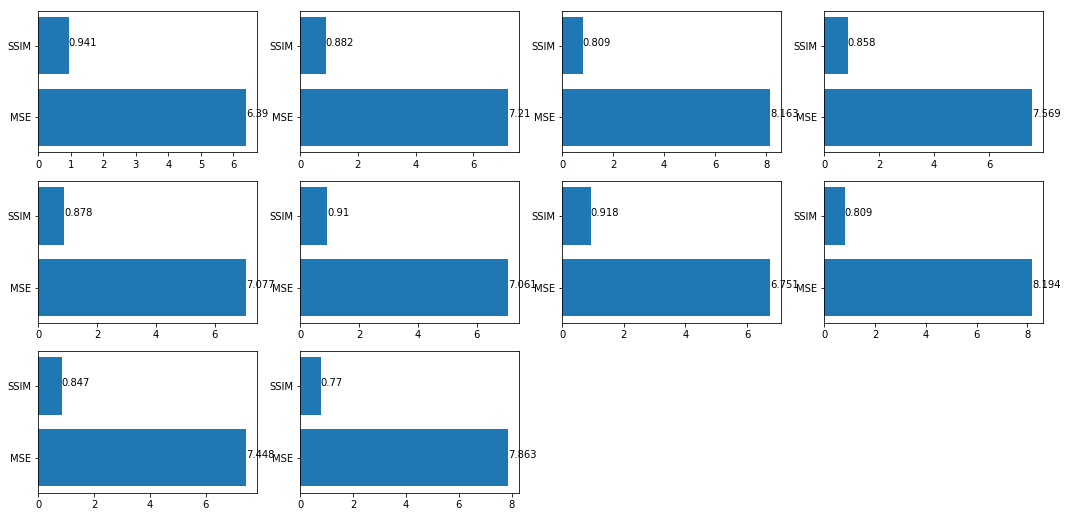

In [112]:
measure = ['MSE', 'SSIM']
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(4,4,1)
value = [round(np.log(float(m1)),3), round((float(s1)),3)]
ax1.barh(measure, value)
for index, val in enumerate(value):
    ax1.text(val, index, str(val))

ax2 = fig.add_subplot(4,4,2)
value = [round(np.log(float(m2)),3), round((float(s2)),3)]
ax2.barh(measure, value)
for index, val in enumerate(value):
    ax2.text(val, index, str(val))

ax3 = fig.add_subplot(4,4,3)
value = [round(np.log(float(m3)),3), round((float(s3)),3)]
ax3.barh(measure, value)
for index, val in enumerate(value):
    ax3.text(val, index, str(val))

ax4 = fig.add_subplot(4,4,4)
value = [round(np.log(float(m4)),3), round((float(s4)),3)]
ax4.barh(measure, value)
for index, val in enumerate(value):
    ax4.text(val, index, str(val))

ax5 = fig.add_subplot(4,4,5)
value = [round(np.log(float(m5)),3), round((float(s5)),3)]
ax5.barh(measure, value)
for index, val in enumerate(value):
    ax5.text(val, index, str(val))

ax6 = fig.add_subplot(4,4,6)
value = [round(np.log(float(m6)),3), round((float(s6)),3)]
ax6.barh(measure, value)
for index, val in enumerate(value):
    ax6.text(val, index, str(val))

ax7 = fig.add_subplot(4,4,7)
value = [round(np.log(float(m7)),3), round((float(s7)),3)]
ax7.barh(measure, value)
for index, val in enumerate(value):
    ax7.text(val, index, str(val))

ax8 = fig.add_subplot(4,4,8)
value = [round(np.log(float(m8)),3), round((float(s8)),3)]
ax8.barh(measure, value)
for index, val in enumerate(value):
    ax8.text(val, index, str(val))

ax9 = fig.add_subplot(4,4,9)
value = [round(np.log(float(m9)),3), round((float(s9)),3)]
ax9.barh(measure, value)
for index, val in enumerate(value):
    ax9.text(val, index, str(val))

ax10 = fig.add_subplot(4,4,10)
value = [round(np.log(float(m10)),3), round((float(s10)),3)]
ax10.barh(measure, value)
for index, val in enumerate(value):
    ax10.text(val, index, str(val))

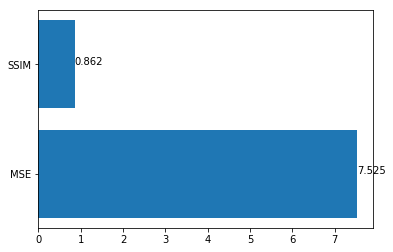

In [115]:
s_avg = (s1+s2+s3+s4+s5+s6+s7+s8+s9+s10)/10
m_avg = (m1+m2+m3+m4+m5+m6+m7+m8+m9+m10)/10

measure = ['MSE', 'SSIM']
value = [round(np.log(float(m_avg)),3), round((float(s_avg)),3)]
plt.barh(measure, value)
for index, val in enumerate(value):
    plt.text(val, index, str(val))

plt.show()